# **About Dataset**

**Problem:** https://www.kaggle.com/competitions/m5-forecasting-accuracy/overview

In the challenge, you are predicting item sales at stores in various locations for two 28-day time periods.

### **Files**
- *calendar.csv* - Contains information about the dates on which the products are sold.
- *sales_train_validation.csv* - Contains the historical daily unit sales data per product and store [d_1 - d_1913]
- *sample_submission.csv* - The correct format for submissions. Reference the Evaluation tab for more info.
- *sell_prices.csv* - Contains information about the price of the products sold per store and date.
- *sales_train_evaluation.csv* - Includes sales [d_1 - d_1941] (labels used for the Public leaderboard)

# **Requirements**

You can use *sales_train_evaluation.csv* as train data and *sales_train_validation.csv* as test data.

### **Steps**
- Make an EDA.
- You can use any methods)
- Write an analysis of your problem: what methods did you use and why.
- Why do you think the competition uses a Weighted Root Mean Squared Scaled Error?

In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/walmart/calendar.csv
/kaggle/input/walmart/sell_prices.csv
/kaggle/input/walmart/sales_train_evaluation.csv


# All needed data: https://drive.google.com/drive/folders/1Rle2Ysxht92-Ot-wRrVk5Y3p2-EJhH2B?usp=drive_link

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Process sales_train.csv

**sales_train_validation.csv** actually contains the same values as **sales_train_evaluation.csv**. The only difference is in the number of date points: 1914 vs 1941. That's why I'll use only the bigger dataset and later split it into train and test

In [3]:
df_train = pd.read_csv('sales_train_evaluation.csv')

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: int64(1941), object(6)
memory usage: 452.9+ MB


In [5]:
df_train[['dept_id', 'cat_id', 'store_id', 'state_id']] = df_train[['dept_id', 'cat_id', 'store_id', 'state_id']].astype('category')

int_columns = df_train.columns[6:]
df_train[int_columns] = df_train[int_columns].astype('int32') 
# i will use type conversion everywhere to reduce memory consumption

In [6]:
df_train.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd_1',
       'd_2', 'd_3', 'd_4',
       ...
       'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938',
       'd_1939', 'd_1940', 'd_1941'],
      dtype='object', length=1947)

### Columns description

• item_id: The id of the product.

• dept_id: The id of the department the product belongs to.

• cat_id: The id of the category the product belongs to.

• store_id: The id of the store where the product is sold.

• state_id: The State where the store is located.

• d_1, d_2, …, d_i, … d_1941: The number of units sold at day i, starting from 2011-01-29.

In [7]:
df_train.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


### Apply pd.melt to move all dates to rows axis

In [8]:
melted = pd.melt(df_train, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sales')

In [9]:
melted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59181090 entries, 0 to 59181089
Data columns (total 8 columns):
 #   Column    Dtype   
---  ------    -----   
 0   id        object  
 1   item_id   object  
 2   dept_id   category
 3   cat_id    category
 4   store_id  category
 5   state_id  category
 6   d         object  
 7   sales     int32   
dtypes: category(4), int32(1), object(3)
memory usage: 1.8+ GB


### Now we can merge sales data with information from other tables

In [10]:
melted.isna().sum()

id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
state_id    0
d           0
sales       0
dtype: int64

In [11]:
items = df_train['item_id'].unique()
melted[melted['item_id'] == items[0]].head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3049,HOBBIES_1_001_CA_2_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_2,CA,d_1,0
6098,HOBBIES_1_001_CA_3_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_3,CA,d_1,0
9147,HOBBIES_1_001_CA_4_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_4,CA,d_1,0
12196,HOBBIES_1_001_TX_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_1,TX,d_1,0


# Process calendar.csv

In [12]:
calendar = pd.read_csv('calendar.csv')

In [13]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


### Columns description

• date: The date in a “y-m-d” format.

• wm_yr_wk: The id of the week the date belongs to.

• weekday: The type of the day (Saturday, Sunday, …, Friday).

• wday: The id of the weekday, starting from Saturday.

• month: The month of the date.

• year: The year of the date.

• event_name_1: If the date includes an event, the name of this event.

• event_type_1: If the date includes an event, the type of this event.

• event_name_2: If the date includes a second event, the name of this event.

• event_type_2: If the date includes a second event, the type of this event.

• snap_CA, snap_TX, and snap_WI: A binary variable (0 or 1) indicating whether the stores of CA, TX or WI allow SNAP purchases on the examined date. 1 indicates that SNAP purchases are allowed.

In [14]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [15]:
calendar['event_type_1'].value_counts()

event_type_1
Religious    55
National     52
Cultural     37
Sporting     18
Name: count, dtype: int64

In [16]:
calendar['event_type_2'].value_counts()

event_type_2
Cultural     4
Religious    1
Name: count, dtype: int64

In [17]:
calendar['event_name_1'].value_counts()

event_name_1
SuperBowl              6
Pesach End             6
Ramadan starts         6
ValentinesDay          6
NBAFinalsEnd           6
NBAFinalsStart         6
MemorialDay            6
Mother's day           6
Purim End              6
StPatricksDay          6
LentWeek2              6
LentStart              6
PresidentsDay          6
MartinLutherKingDay    5
OrthodoxChristmas      5
EidAlAdha              5
NewYear                5
Chanukah End           5
Christmas              5
Thanksgiving           5
VeteransDay            5
IndependenceDay        5
Halloween              5
ColumbusDay            5
LaborDay               5
Eid al-Fitr            5
Cinco De Mayo          5
OrthodoxEaster         5
Easter                 5
Father's day           4
Name: count, dtype: int64

### Do one hot encoding for calendar

In [18]:
calendar = pd.get_dummies(calendar, columns=['event_type_1', 'event_type_2', 'event_name_1', 'event_name_2', 'weekday'])
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 56 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   date                              1969 non-null   object
 1   wm_yr_wk                          1969 non-null   int64 
 2   wday                              1969 non-null   int64 
 3   month                             1969 non-null   int64 
 4   year                              1969 non-null   int64 
 5   d                                 1969 non-null   object
 6   snap_CA                           1969 non-null   int64 
 7   snap_TX                           1969 non-null   int64 
 8   snap_WI                           1969 non-null   int64 
 9   event_type_1_Cultural             1969 non-null   bool  
 10  event_type_1_National             1969 non-null   bool  
 11  event_type_1_Religious            1969 non-null   bool  
 12  event_type_1_Sportin

### Join the information about event names and types into one column

In [19]:
calendar['event_type_1_Cultural'] = calendar[['event_type_1_Cultural', 'event_type_2_Cultural']].max(axis=1)
calendar['event_type_1_Religious'] = calendar[['event_type_1_Religious', 'event_type_2_Religious']].max(axis=1)

calendar['event_name_1_Cinco De Mayo'] = calendar[['event_name_1_Cinco De Mayo', 'event_name_2_Cinco De Mayo']].max(axis=1)
calendar['event_name_1_Easter'] = calendar[['event_name_1_Easter', 'event_name_2_Easter']].max(axis=1)
calendar['event_name_1_Father\'s day'] = calendar[['event_name_1_Father\'s day', 'event_name_2_Father\'s day']].max(axis=1)
calendar['event_name_1_OrthodoxEaster'] = calendar[['event_name_1_OrthodoxEaster', 'event_name_2_OrthodoxEaster']].max(axis=1)

calendar.drop(columns=['event_type_2_Cultural', 'event_type_2_Religious', 'event_name_2_Cinco De Mayo',
                       'event_name_2_Father\'s day', 'event_name_2_OrthodoxEaster', 'event_name_2_Easter'], inplace=True)

In [20]:
rename_mapping_1 = {col: col.replace('event_name_1_', 'event_name_') for col in calendar.columns if col.startswith('event_name_1_')}
rename_mapping_2 = {col: col.replace('event_type_1_', 'event_type_') for col in calendar.columns if col.startswith('event_type_1_')}

# Rename columns
calendar.rename(columns=rename_mapping_1, inplace=True)
calendar.rename(columns=rename_mapping_2, inplace=True)

In [21]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 50 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   date                            1969 non-null   object
 1   wm_yr_wk                        1969 non-null   int64 
 2   wday                            1969 non-null   int64 
 3   month                           1969 non-null   int64 
 4   year                            1969 non-null   int64 
 5   d                               1969 non-null   object
 6   snap_CA                         1969 non-null   int64 
 7   snap_TX                         1969 non-null   int64 
 8   snap_WI                         1969 non-null   int64 
 9   event_type_Cultural             1969 non-null   bool  
 10  event_type_National             1969 non-null   bool  
 11  event_type_Religious            1969 non-null   bool  
 12  event_type_Sporting             1969 non-null   

In [22]:
calendar.drop(columns=['date', 'wday'], inplace=True)

calendar[['wm_yr_wk', 'month', 'year']] = calendar[['wm_yr_wk', 'month', 'year']].astype('int32')
calendar[['snap_CA', 'snap_TX', 'snap_WI']] = calendar[['snap_CA', 'snap_TX', 'snap_WI']].astype('bool')

# Process sell_prices.csv

In [23]:
sell_prices = pd.read_csv('sell_prices.csv')

In [24]:
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [25]:
sell_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [26]:
sell_prices['store_id'] = sell_prices['store_id'].astype('category')
sell_prices['wm_yr_wk'] = sell_prices['wm_yr_wk'].astype('int32')
sell_prices['sell_price'] = sell_prices['sell_price'].astype('float32')

In [27]:
items = sell_prices['item_id'].unique()
data = sell_prices[sell_prices['item_id'] == items[0]]['sell_price']
data

0          9.58
1          9.58
2          8.26
3          8.26
4          8.26
           ... 
6145173    8.38
6145174    8.38
6145175    8.38
6145176    8.38
6145177    8.38
Name: sell_price, Length: 1528, dtype: float32

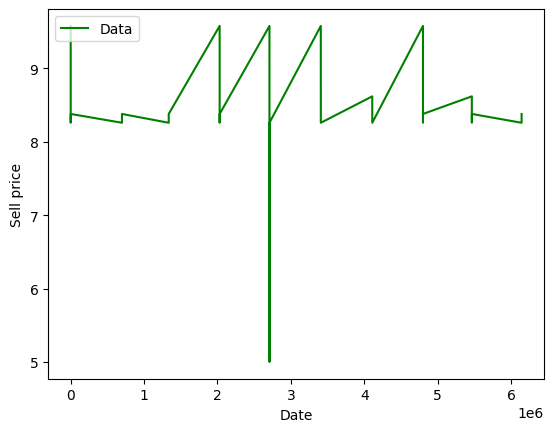

In [28]:
fig, ax = plt.subplots()
ax.plot(data, 'g', label='Data')
ax.set_xlabel('Date')
ax.set_ylabel('Sell price') 
ax.legend(loc=2)

### The sell prices for all prices are more or less stationary, that's why further it would be quite good to fill missing values with average price of a particular item

### Merge melted with calendar

In [29]:
melted_calendar = pd.merge(melted, calendar, on='d', how='left')

In [30]:
merged = pd.merge(melted_calendar, sell_prices, how='left', on=['item_id', 'store_id', 'wm_yr_wk'])

In [31]:
import gc

del melted, melted_calendar
gc.collect()

30

In [32]:
merged['index_id'] = merged['id'] + '_' + merged['d']

In [33]:
merged['sell_price'].isna().sum()

12299413

### Calculate values to fill NaNs with mean, which generally keeps data stationarity

In [34]:
avg_prices = sell_prices.groupby(['store_id', 'item_id'])['sell_price'].mean()

avg_prices = avg_prices.reset_index()
avg_prices.rename(columns={'sell_price':'mean_price'}, inplace=True)
avg_prices['mean_price'] = avg_prices['mean_price'].astype('float32')

/tmp/ipykernel_33/1736118547.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_prices = sell_prices.groupby(['store_id', 'item_id'])['sell_price'].mean()


# Finally merge calendar, sales and prices information into one dataframe

In [35]:
merged = pd.merge(merged, avg_prices, how='left', on=['item_id', 'store_id'])

### Fill missimg values

In [36]:
merged['sell_price'] = merged['sell_price'].fillna(merged['mean_price'])

In [37]:
# all NaNs removed
merged['sell_price'].isna().sum()

0

In [38]:
merged.drop(columns=['id', 'item_id'], inplace=True)

### One hot encode **'dept_id', 'cat_id', 'store_id', 'state_id'** columns

In [39]:
merged = pd.get_dummies(data=merged, columns=['dept_id', 'cat_id', 'store_id', 'state_id'])

### Train a model

In [40]:
merged.drop(columns=['index_id', 'mean_price'], inplace=True)

In [41]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59181090 entries, 0 to 59181089
Data columns (total 73 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   d                               object 
 1   sales                           int32  
 2   wm_yr_wk                        int32  
 3   month                           int32  
 4   year                            int32  
 5   snap_CA                         bool   
 6   snap_TX                         bool   
 7   snap_WI                         bool   
 8   event_type_Cultural             bool   
 9   event_type_National             bool   
 10  event_type_Religious            bool   
 11  event_type_Sporting             bool   
 12  event_name_Chanukah End         bool   
 13  event_name_Christmas            bool   
 14  event_name_Cinco De Mayo        bool   
 15  event_name_ColumbusDay          bool   
 16  event_name_Easter               bool   
 17  event_name_Eid al-Fitr   

### Combine 'snap' columns into one

In [42]:
merged['snap'] = 0
merged['snap'] = merged['snap'].astype('bool')

merged.loc[:, 'snap'] = merged['state_id_CA'] & merged['snap_CA']
merged.loc[:, 'snap'] = merged['state_id_TX'] & merged['snap_TX']
merged.loc[:, 'snap'] = merged['state_id_WI'] & merged['snap_WI']

merged.drop(columns=['snap_CA', 'snap_TX', 'snap_WI'], inplace=True)

### Scale numeric columns with Standard Scaler. Divide target variable 'sales' by max_value to keep it positive (it is required by the LightGBM model)

In [ ]:
from sklearn.preprocessing import StandardScaler

sales_max = merged['sales'].max()
merged.loc[:, 'sales'] = merged['sales'] / sales_max

In [44]:
scaler = StandardScaler()
scaler.fit(merged[['wm_yr_wk', 'month', 'year', 'sell_price']])

StandardScaler()

In [ ]:
# transform using scaler
merged.loc[:, ['wm_yr_wk', 'month', 'year', 'sell_price']] = scaler.transform(merged[['wm_yr_wk', 'month', 'year', 'sell_price']])

In [46]:
merged[['wm_yr_wk', 'sales', 'month', 'year', 'sell_price']] = merged[['wm_yr_wk', 'sales', 'month', 'year', 'sell_price']].astype('float32')

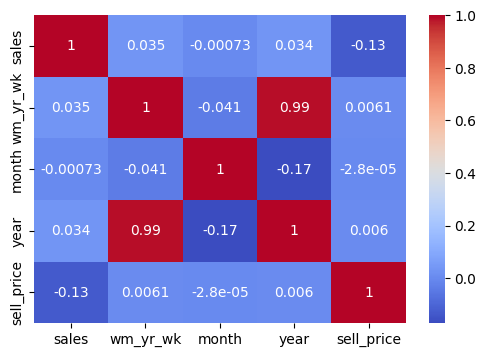

In [47]:
import seaborn as sns

df_selected = merged.select_dtypes(include=['number'])
correlation_matrix = df_selected.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

### Heatmap shows a big correlation between **year** and **wm_yr_wk** features

In [48]:
merged.drop(columns='wm_yr_wk', inplace=True)

# Split data into train and test 

In [49]:
merged_train = merged[merged['d'].str[2:].astype(int) < 1314]
merged_test = merged[merged['d'].str[2:].astype(int) >= 1514]

### I found the size of train dataset experimentally to reduce memory consumption and it's overflow during the trainig process

In [50]:
del merged

In [51]:
cols = [col for col in merged_train.columns if col not in ['d', 'sales']]

X_train = merged_train[cols]
y_train = merged_train['sales']

X_test = merged_test[cols]
y_test = merged_test['sales']

In [52]:
del merged_train, merged_test
gc.collect()

7025

# Use Ridge model to select important features
I also tried Lasso, but it gives zero coefficients for every feature, no matter which *alpha* parameter I use

In [53]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.1)
ridge.fit(X_test, y_test)

Ridge(alpha=0.1)

In [54]:
significant_mask = np.abs(ridge.coef_) >= 1e-4
significant_features_ridge = X_test.columns[significant_mask]
significant_coefficients = ridge.coef_[significant_mask]

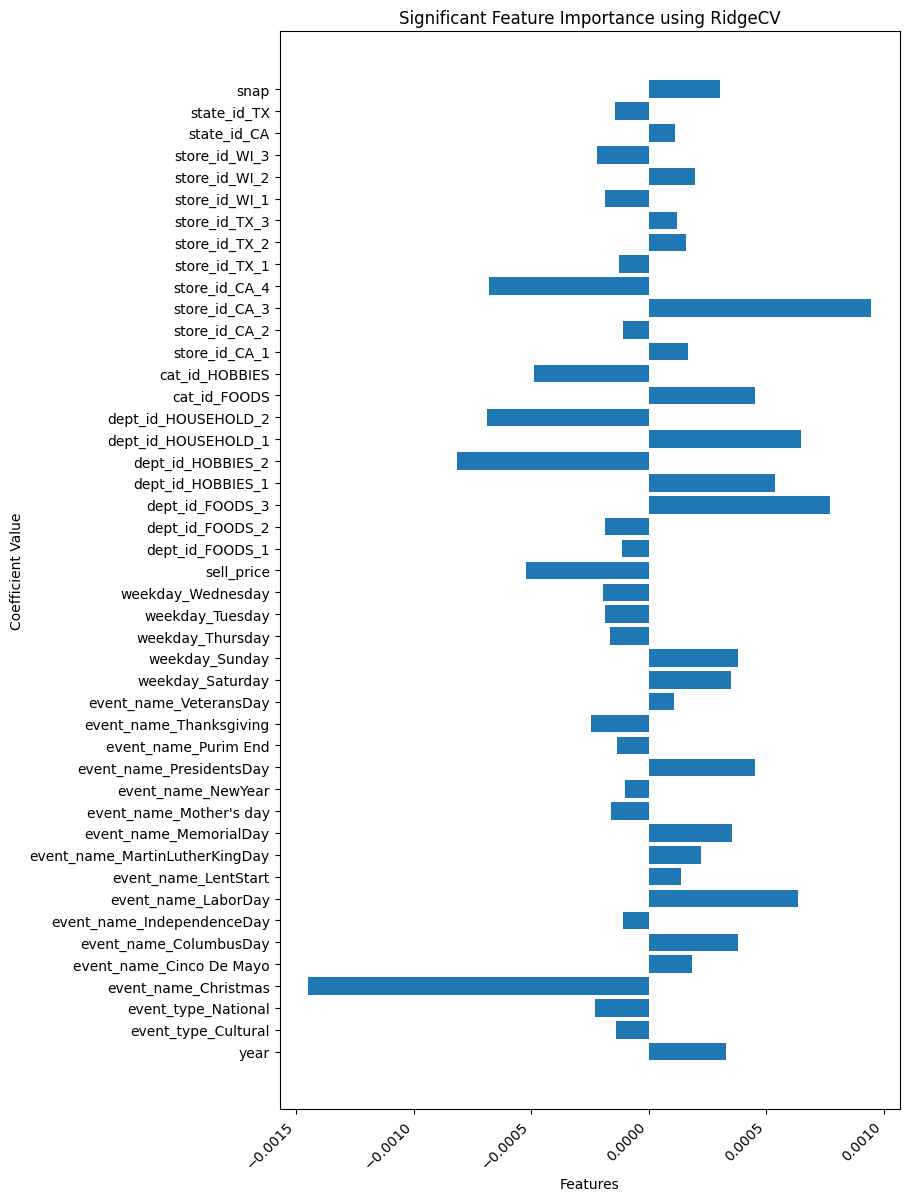

In [55]:
plt.figure(figsize=(8, 14))
plt.barh(significant_features_ridge, significant_coefficients)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Significant Feature Importance using RidgeCV')
plt.xticks(rotation=45, ha="right")  # Rotate feature names for better readability
plt.show()

In [56]:
len(significant_features_ridge)

45

In [57]:
nonsignificant_features_ridge = X_test.columns[significant_mask == False]
len(nonsignificant_features_ridge)

23

In [58]:
X_train = X_train.drop(nonsignificant_features_ridge, axis=1)
X_test = X_test.drop(nonsignificant_features_ridge, axis=1)

In [59]:
del df_train, calendar, sell_prices, items, data, avg_prices, df_selected
gc.collect()

9721

# Before applying GB model, try predicting with **DummyRegressor**

In [60]:
from sklearn.dummy import DummyRegressor

dummy_regr = DummyRegressor(strategy="median")
dummy_regr.fit(X_train, y_train)

DummyRegressor(strategy='median')

In [61]:
from sklearn.metrics import mean_squared_error as mse

dummy_y_test = dummy_regr.predict(X_test)
print("Dummy Test RMSE: ", np.sqrt(mse(y_test * sales_max, dummy_y_test * sales_max)))

Dummy Test RMSE:  3.8251238


# Train and predict using LGBMRegressor
Due to the size of the dataset (about 40 million rows and 45 columns) time and memory efficiency is significant, so LightGBM, I suppose, is a good choice

In [62]:
from lightgbm import LGBMRegressor

In [63]:
model = LGBMRegressor(boosting_type='gbdt', learning_rate=0.0001, n_estimators=500)

In [64]:
model.fit(X_train, y_train, eval_metric='rmse')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 3.328893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 40033370, number of used features: 45
[LightGBM] [Info] Start training from score 0.001407


LGBMRegressor(learning_rate=0.0001, n_estimators=500)

In [ ]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [115]:
print("LGBM Train RMSE: ", np.sqrt(mse(y_train * sales_max, y_train_pred * sales_max)))
print("LGBM Test RMSE: ", np.sqrt(mse(y_test * sales_max, y_test_pred * sales_max)))

LGBM Train RMSE:  3.741047855276597
LGBM Test RMSE:  3.4123954901474756


LGBM Train RMSE:  3.741047855276597
LGBM Test RMSE:  3.4123954901474756

### LGBM score is ~12% better

In [119]:
model.booster_.save_model('model_bigger.txt')

In [120]:
compare = pd.DataFrame({'test' : y_test * sales_max, 'predict' : y_test_pred * sales_max})

In [121]:
compare

,test,predict
46131370,2.0,0.607975
46131371,0.0,0.607975
46131372,1.0,0.696345
46131373,10.0,0.607975
46131374,3.0,0.696345
...,...,...
59181085,1.0,1.042613
59181086,0.0,1.042613
59181087,2.0,1.042613
59181088,0.0,3.773486


# Thoughts about prediction results

The main reason that the error hasn't redused as much as expected, in my opinion, is that the data is definitely **time-based**. So it may require time-series approach in data analysis and it's prediction, for example, the SARIMAX model. However, having 30490 time-series may be really time consuming, especially when LightGBM itself needs half an hour to get a model above. 

# The choice of RMSE

Evaluating model on RMSE gives better results when the residuals are normally distributed (which is usually true in case of normal distributed target values). However, the unit_sales data in this competition is closer to the Laplacian distribution having a long right tale and some outliers, while most of data lies within the first quantile. This may be the reason of weighting and scaling values when calculating a **Weighted Root Mean Squared Scaled Error (RMSSE)**